# Parallel execution of EasyVVUQ workflows with QCG-PilotJob - EasyVVUQ-QCGPJ API
In this Notebook we present how to employ the *EasyVVUQ-QCGPJ* API to enable efficient execution of *EasyVVUQ* workflows on large computing resources. The API extends capabilities of a regular *EasyVVUQ* with the dedicated procedures for interracting with the *QCG-PilotJob* system, enabling the execution of the most demanding parts of the workflow in parallel.

## Installing EasyVVUQ-QCGPJ
The first thing that you need to do in order to install *EasyVVUQ-QCGPJ*, is the installation of its dependencies, namely *EasyVVUQ* and *QCG-PilotJob*. It can be done in the following way:

In [1]:
pip install easyvvuq qcg-pilotjob

  Using cached easyvvuq-0.7.1.5-py3-none-any.whl (182 kB)
  Using cached qcg_pilotjob-0.9.0-py3-none-any.whl (116 kB)
  Using cached pandas-1.1.4-cp37-cp37m-manylinux1_x86_64.whl (9.5 MB)
  Using cached jsonpickle-1.4.1-py2.py3-none-any.whl (36 kB)
Processing /home/jovyan/.cache/pip/wheels/17/3a/0d/e2fc48cf85cb858f5e65f1baa36180ebb5dce6397c35c4cfcb/Cerberus-1.3.2-py3-none-any.whl
  Using cached dask_jobqueue-0.7.1-py2.py3-none-any.whl (38 kB)
  Using cached chaospy-4.0.2-py2.py3-none-any.whl (240 kB)
  Using cached scikit_learn-0.23.2-cp37-cp37m-manylinux1_x86_64.whl (6.8 MB)
  Using cached kubernetes-12.0.0-py3-none-any.whl (1.7 MB)
  Using cached cloudpickle-1.6.0-py3-none-any.whl (23 kB)
     |████████████████████████████████| 25.9 MB 811 bytes/s a 0:00:01         | 5.6 MB 1.8 MB/s eta 0:00:12��█▌                      | 7.6 MB 1.8 MB/s eta 0:00:11                 | 8.5 MB 7.7 MB/s eta 0:00:03��███████▏                  | 10.7 MB 7.7 MB/s eta 0:00:02��███████████████             | 15

The actual installation of *EasyVVUQ-QCGPJ* is also strightforward:

In [2]:
pip install easyvvuq-qcgpj

  Using cached pytest_flake8-1.0.6-py2.py3-none-any.whl (6.3 kB)
  Using cached flake8-3.8.4-py2.py3-none-any.whl (72 kB)
  Using cached pycodestyle-2.6.0-py2.py3-none-any.whl (41 kB)
  Using cached mccabe-0.6.1-py2.py3-none-any.whl (8.6 kB)
  Using cached pyflakes-2.2.0-py2.py3-none-any.whl (66 kB)
  Created wheel for easyvvuq-qcgpj: filename=easyvvuq_qcgpj-0.4.1-py3-none-any.whl size=10761 sha256=5fbd3f20fa682225b193d79f3ad3238491ba87c45c1348e287a7e155190722da
  Stored in directory: /home/jovyan/.cache/pip/wheels/e4/0e/60/481a898e18830ea39ed7932c7b5a11c73e135801c5d68a08ca
Successfully built easyvvuq-qcgpj
Note: you may need to restart the kernel to use updated packages.


## Getting tutorial files
The next action is to get files that will be used in the tutorial:

In [3]:
!git clone https://github.com/vecma-project/EasyVVUQ-QCGPJ.git

Cloning into 'EasyVVUQ-QCGPJ'...
remote: Enumerating objects: 368, done.
remote: Counting objects: 100% (368/368), done.
remote: Compressing objects: 100% (202/202), done. (188/202)
remote: Total 924 (delta 239), reused 249 (delta 159), pack-reused 556
Receiving objects: 100% (924/924), 1.41 MiB | 3.24 MiB/s, done.
Resolving deltas: 100% (528/528), done.


$$
\def\CC{\bf C}
\def\QQ{\bf Q}
\def\RR{\bf R}
\def\ZZ{\bf Z}
\def\NN{\bf N}
$$
## A Cooling Coffee Cup with Polynomial Chaos Expansion using EasyVVUQ-QCGPJ

In order to keep the conformance with the basic *EasyVVUQ* tutorial we will show the same workflow as it was used in that tutorial's use-case, i.e. the scenario of Polynomial Chaos Expansion for a model of a cooling coffee cup.  

### The Cooling Coffee Cup model

In order to recall the idea of the scenario, let us shortly describe the physical basics. 

The model uses Newton's law of cooling to
evolve the temperature, $T$, over time ($t$) in an environment at
$T_{env}$ :

$$\frac{dT(t)}{dt} = -\kappa (T(t) -T_{env})$$

The constant $\kappa$ characterizes the rate at which the coffee cup
transfers heat to the environment. In this example we will analyze this
model using the polynomial chaos expansion (PCE) UQ algorithm. We will
use a constant initial temperature $T_0 = 95 ^\circ\text{C}$, and vary
$\kappa$ and $T_{env}$ using a uniform distribution in the ranges
$0.025-0.075$ and $15-25$ respectively.

### EasyVVUQ Script Overview

As it was already said, the origin of the scenario for this tutorial is the UQ analysis of cooling cofee cup model delivered as a primary *EasyVVUQ* example. 
Once the *EasyVVUQ-QCGPJ* sources are checked-out from GitHub, the python code for the model is available in `EasyVVUQ-QCGPJ/tests/cooling/cooling_model.py` and the template used for the encoding of input for this model is available in `EasyVVUQ-QCGPJ/tests/cooling/cooling.template`. 

Since the approach we took to integrate *EasyVVUQ* with *QCG Pilot Job Manager* is considerably non-intrusive, the original *EasyVVUQ* workflow for the scenario (the one without *QCG-PilotJob*) requires only slight modifications to run with the *QCG-PilotJob* mechanism. The crucial ammendment introduced into the current tutorial, is the replacement of basic way of execution of *EasyVVUQ* tasks by *EasyVVUQ-QCGPJ* *encoding* and *execution* routines to perform most demanding computations using the *QCG-PilotJob* system. 
In the rest of this notebook the whole ammended workflow is presented, however in order to not disturb your attention from the main topic of this tutorial, we concentrate on the part related to *EasyVVUQ-QCGPJ* code itself. If you want to know something more about other parts of the workflow please refer to the *EasyVVUQ* documentation or to the basic *EasyVVUQ* tutorial. 

### Setup
In the first step we need to import requied dependencies. In addition to chaospy and easyvvuq we need to import a few classes from *EasyVVUQ-QCGPJ* (`easypj` package)   

In [4]:
import os
import chaospy as cp
import easyvvuq as uq

from eqi import Executor, Task, TaskType, TaskRequirements, SubmitOrder

Next we will set a couple of helper variables, which are specific for our example:

### Campaign initialisation
EasyVVUQ-QCGPJ doesn't alter the way how EasyVVUQ campaign is created and inited.
The whole initialisation code from the original example can be simply reused with only a minor changes to adjust paths to a local environment. After these small modifications it looks as follows: 

In [5]:
# Initialize Campaign
my_campaign = uq.Campaign(name='coffee_pce')


params = {
    "temp_init": {"type": "float", "min": 0.0, "max": 100.0, "default": 95.0},
    "kappa": {"type": "float", "min": 0.0, "max": 0.1, "default": 0.025},
    "t_env": {"type": "float", "min": 0.0, "max": 40.0, "default": 15.0},
    "out_file": {"type": "string", "default": "output.csv"}
}

encoder = uq.encoders.GenericEncoder(
    template_fname=os.path.abspath('EasyVVUQ-QCGPJ/tests/cooling/cooling.template'),
    delimiter='$',
    target_filename="cooling_in.json")

decoder = uq.decoders.SimpleCSV(target_filename="output.csv",
                                output_columns=["te"],
                                header=0)

collater = uq.collate.AggregateSamples(average=False)

# Add the app (automatically set as current app)
my_campaign.add_app(name="cooling",
                    params=params,
                    encoder=encoder,
                    decoder=decoder,
                    collater=collater)

# Setup sampler
vary = {
    "kappa": cp.Uniform(0.025, 0.075),
    "t_env": cp.Uniform(15, 25)
}

my_sampler = uq.sampling.PCESampler(vary=vary, polynomial_order=3)
my_campaign.set_sampler(my_sampler)

# Draw samples
my_campaign.draw_samples()

print("Campaign prepared")
print(my_campaign)

Campaign prepared
db_location = sqlite:////home/jovyan/tutorials/VECMAtk/EasyVVUQ-QCGPJ/coffee_pce0_xb910b/campaign.db
active_sampler_id = 1
campaign_name = coffee_pce
campaign_dir = /home/jovyan/tutorials/VECMAtk/EasyVVUQ-QCGPJ/coffee_pce0_xb910b
campaign_id = 1
log = [{'element': {'name': 'PCE_sampler', 'version': '0.5', 'category': 'sampling'}, 'info': {'num_added': 16, 'replicas': 1}}]



### EASYVVUQ-QCGPJ part
In this place we start definitions specific for *EasyVVUQ-QCGPJ*. 
#### EasyVVUQ-QCGPJ Executor
*EasyVVUQ-QCGPJ* provides the `Executor` class that manages the execution of potentially computationally-intensive *EasyVVUQ* operations processed on samples, in particular the encoding and model execution. The first step is to construct the `Executor` instance.

In [6]:
qcgpjexec = Executor(my_campaign)

Campaign dir:/home/jovyan/tutorials/VECMAtk/EasyVVUQ-QCGPJ/coffee_pce0_xb910b
QCG-PJ temp dir:/home/jovyan/tutorials/VECMAtk/EasyVVUQ-QCGPJ/coffee_pce0_xb910b/.qcgpj-el1egd5w


#### Initialisation of QCG-PilotJob Manager
Now the executor needs to be connected with *QCG-PilotJob Manager* instance. The easiest way is to use a dedicated method `create_manager`. In case of the execution of the workflow inside a SLURM computing job, the method could be invoked even without arguments. Here, since we are not in a regular allocation on HPC machine, we have to use *QCG-PilotJob Manager* in so called *local mode*. It means that we have to manually instruct the service how many resources (possibly virtual ones) we want to use. 

In [7]:
qcgpjexec.create_manager(resources='4')

log file set to /home/jovyan/tutorials/VECMAtk/EasyVVUQ-QCGPJ/coffee_pce0_xb910b/.qcgpj-el1egd5w/api.log


#### EasyVVUQ-QCGPJ Tasks

The next step is the setup of tasks skeletons, that will be used to generate specific tasks for the execution of demanding *EasyVVUQ* operations inside the *QCG-PilotJob* manager. To this end the `Executor` class provides a method called `add_task` that takes `Task` as an argument. In order to create a `Task` you need to provide its type, requirements and possibly Task type specific parameters. In our example we will define two tasks: `TaskType.ENCODING` for the input parameters encoding and `TaskType.EXECUTION` for the model execution. 

##### *Encoding task*
With the following task definition we specify that each encoding of a sample should be executed on a single core:

In [8]:
qcgpjexec.add_task(Task(
    TaskType.ENCODING,
    TaskRequirements(cores=1)
))

##### *Model execution task*
The task definition for a model execution is a bit more complicated. Along with the type, and requirements, we need to specify the application that will be executed for each sample. Thus the constructor for this task type takes one additional named parameter, called `application`. In this example we specify that our application is a python model that takes the encoded file (`cooling_model.py`) as an input. As you can see, for the execution of tasks of this kind we request for 4 cores.  

In [9]:
qcgpjexec.add_task(Task(
    TaskType.EXECUTION,
    TaskRequirements(cores=4),
    application='python3 ' + os.path.abspath("EasyVVUQ-QCGPJ/tests/cooling/cooling_model.py") + " cooling_in.json"
))

<div style="color: gray; border: dotted 1px gray; padding: 8px">
    <b>Note:</b> there is also a third type of Task in EasyVVUQ-QCGPJ, namely TaskType.EXECUTION_ENCODING. This type of a task can be defined to enable integrated run of encoding and model execution for a sample inside a single QCG-PilotJob task.
</div>

#### Run encodings and executions with EasyVVUQ-QCGPJ 
Once all the above steps are completed, we can use *Executor's* `run` method to encode and execute all samples stored in a `Campaing` using *QCG-PilotJob*. The first parameter of the `run` method is the `campaing` object itself. The method gives also the possibility to select a `submit_order`'s. Here we select the `SubmitOrder.RUN_ORIENTED` scheme, which means that the tasks are submitted in a priority of RUN (sample); in other words we want to complete whole processing (encoding and execution) for a given sample as soon as possible and then go to the next sample. 

In [10]:
qcgpjexec.run(submit_order=SubmitOrder.RUN_ORIENTED)

Starting submission of tasks to QCG-PilotJob Manager
Syncing state of campaign after execution of PJ


<div style="color: gray; border: dotted 1px gray; padding: 8px">
    <b>Note:</b> EasyVVUQ-QCGPJ provides a few SubmitOrder schemes, namely: RUN_ORIENTED, PHASE_ORIENTED, RUN_ORIENTED_CONDENSED or EXECUTION_ONLY. Depending on your use-case it may be more beneficial to select one scheme than the other. You can find description of the SubmitOrders at the http://easyvvuq-qcgpj.readthedocs.io. 
</div>

#### Terminate QCG-PilotJob Manager
When you completed the execution, the QCG-PilotJob Manager service still waits on possible further connections. The good practice is to terminate it.

In [11]:
qcgpjexec.terminate_manager()

At this place the code specific for *EasyVVUQ-QCGPJ* ends. We can continue with the pure *EasyVVUQ* code.

### Collating data and analysis
Now we can collate generated results and then make analysis in a typical for *EasyVVUQ* way. The code below is simply a copy from the example distributed with the *EasyVVUQ*. Therefore, if you want to get more information about the logic behind these code please go to the basic *EasyVVUQ* tutorial.  

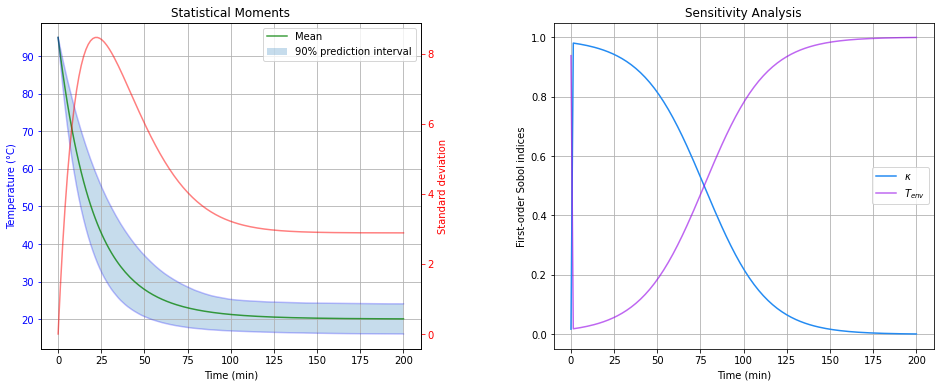

In [12]:
my_campaign.collate()

my_analysis = uq.analysis.PCEAnalysis(sampler=my_sampler, qoi_cols=["te"])
my_campaign.apply_analysis(my_analysis)

results = my_campaign.get_last_analysis()
stats = results['statistical_moments']['te']
per = results['percentiles']['te']
sobols = results['sobols_first']['te']

import matplotlib.pyplot as plt
import numpy as np
mean = stats["mean"]
std = stats["std"]
p10 = per["p10"]
p90 = per["p90"]

s1_kappa = sobols["kappa"]
s1_t_env = sobols["t_env"]

t = np.linspace(0, 200, 150)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

ax1.plot(t, mean, 'g-', alpha=0.75, label='Mean')
ax1.plot(t,  p10, 'b-', alpha=0.25)
ax1.plot(t,  p90, 'b-', alpha=0.25)
ax1.fill_between(
  t,
  p10,
  p90,
  alpha=0.25,
  label='90% prediction interval')
ax1.set_xlabel('Time (min)')
ax1.set_ylabel('Temperature (°C)', color='b')
ax1.tick_params('y', colors='b')
ax1.legend()

ax1t = ax1.twinx()
ax1t.plot(t, std, 'r-', alpha=0.5)
ax1t.set_ylabel('Standard deviation', color='r')
ax1t.tick_params('y', colors='r')

ax1.grid()
ax1.set_title('Statistical Moments')

ax2.plot(t, s1_kappa[0], '-', color ='#248BF2', label=r'$\kappa$')
ax2.plot(t, s1_t_env[0], '-', color ='#9402E8', alpha=0.6,label=r'$T_{env}$')

ax2.set_xlabel('Time (min)')
ax2.set_ylabel('First-order Sobol indices')
ax2.set_title('Sensitivity Analysis')
ax2.grid()
ax2.legend()

plt.subplots_adjust(wspace=0.35)

plt.show()

## Clean

### Clean outputs

In [13]:
!rm -rf coffee_pce*
!rm -rf .qcg*
print("Done")

Done


### Clean deployment

In [14]:
!rm -rf EasyVVUQ-QCGPJ
print("Done")

Done
